In [242]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import scipy
import itertools
import ruptures as rpt
from algorithms.utils import *

In [243]:
def estimate_samples(eta, tau, eps, theta = 0.1):
    gamma = 0.57721567
    D = get_D(epsilon,tau)
    if eps>eta/2:
        return None
    A = (2.07/np.pi*(np.log(4*D) + gamma)+1)
    M_ = (A/(eta/2-eps))**2 *(np.log(np.log(1/(tau*eps))) + np.log(1/theta))
    return M_

def get_D(eps,tau=tau):
  
    # D = 2.07/(2*np.pi)*(2*np.log2(2)+np.log(d+0.5)+0.577 + 0.5/(d+0.5))
    D = np.sqrt(2)/(tau*eps)*np.log(4*np.sqrt(2*np.pi/(tau*eps))*(2+tau/eps))
    return D

def f_distribution(x, d_b, d_w):
    "F-distribution given `d_b` between DF and `d_w` within DF."
    return (d_b/d_w)**(d_b/2)*x**(d_b/2-1)*(1+x*d_b/d_w)**(-(d_b+d_w)/2)/scipy.special.beta(d_b/2, d_w/2)

In [44]:
D = 1000
e = fsolve(lambda x:get_D(x,tau)-D,0.01)



[0.01529311] [1000.]


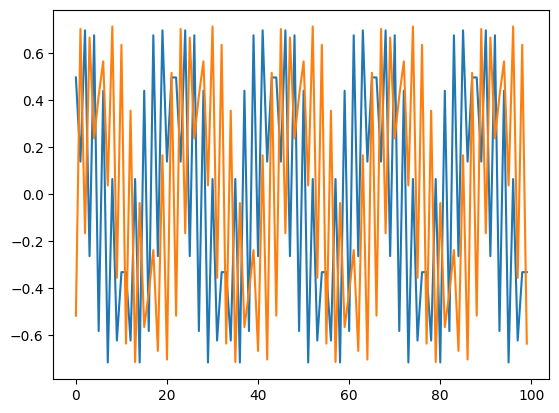

In [224]:
ews = [-0.1,1]

tau = np.pi/2/(np.sum(np.absolute(ews)))

def get_moments(eta,tau,D):
     return np.array([eta*np.exp(-1.j*tau *n*ews[0])+(1-eta)*np.exp(-1.j*tau*n*ews[1]) for n in range(1,2*D+1,2)])

moments = get_moments(eta,tau,D=100)

plt.plot(moments.real)
plt.plot(moments.imag)



In [190]:
beta = 100 
d = 10

K = np.arange(0,d+1)
Fk = [get_F(k,beta,d) for k in K]
Fk = np.array(Fk)  #get the coefficients

print(Fk)
print(tau)

[0.-0.31791125j 0.-0.10491337j 0.-0.06169855j 0.-0.04276489j
 0.-0.03195451j 0.-0.02486692j 0.-0.01981363j 0.-0.01600901j
 0.-0.01303808j 0.-0.0106605j  0.-0.00459291j]
0.7853981633974483


In [ ]:
from algorithms.Fk import get_F, get_beta

D = 4*np.logspace(1,3,15) 
# D = [100]

grid  = np.linspace(-np.pi/2,np.pi/2,2000)


# plt.xscale('log')
# plt.yscale('log')
M = []
M_signal = []
# D = [3000]
nbr_sigma = 1
for d in D:
    
    d = int(np.ceil(d))
    if d>500:
        nbr_sigma = 2
    print('D = {}'.format(d))
    res = 10 
    x0 = 0.1
    while res>10**-4:
        epsilon = fsolve(lambda x:get_D(x,tau)-d,x0)[0]
        res = np.absolute(get_D(epsilon)-d)
        x0/=10 
        if x0<10**-10:
            print('breaking eps')
            break
   
    delta = epsilon*tau
    eta = 4*epsilon
    if eta>1:
        eta = 3*epsilon 
        
    print(epsilon,eta)
    beta = get_beta(epsilon,delta)
    m = estimate_samples(eta, tau, epsilon, theta = 0.05)
    M.append(m)
    ##### empirical ###### 
    
    K = np.arange(0,d+1)
    Fk = [get_F(k,beta,d) for k in K]
    Fk = np.array(Fk)  #get the coefficients

    norm_Fk   = np.sum(np.absolute(Fk))
    probs_Fk  = (np.absolute(Fk)/norm_Fk).real
    
    moments = get_moments(eta,tau,d)
    gk_real = moments.real 
    prob_real = (gk_real+1)/2
    
    gk_imag = moments.imag 
    
    prob_imag = (gk_imag+1)/2 

   
    shot = 100
    shot_floor = 0 
    flag = True
    while flag:
        print('trying {} shots'.format(shot))
        if shot>M[-1]:
            print('breaking')
            break 
        guesses = []
        # plt.figure()
        for _ in range(10):
            
            sample_k  = list(np.random.choice(np.arange(d+1),size = shot, p=probs_Fk,replace=True)) #sample
            sample_k.sort()
        
            elements  = np.array([[g[0], len(list(g[1]))] for g in itertools.groupby(sample_k)])
            ks = elements[:,0]
            shots = elements[:,1]
        
            coeffs   = list(norm_Fk/shot *np.ones_like(ks))
        
            
            pseudo_prob = np.array([ np.sum(2*np.random.binomial(1,p=prob_real[ks[i]],size = shots[i])-1) for i in range(len(shots))])
            gk_real = pseudo_prob
    
            pseudo_prob = np.array([np.sum(2*np.random.binomial(1,p=prob_imag[ks[i]],size = shots[i])-1) for i in range(len(shots))])
            gk_imag = pseudo_prob
            
           
            
            J = 2*np.array(ks)+1 
    
            out = np.outer(J,grid)
            acdf = 0.5 + 2*np.array(np.einsum('i, ij', coeffs*gk_real, np.sin(out))
                         + np.einsum('i, ij', coeffs*gk_imag, np.cos(out)) )
            
        
            empirical_sigma = np.sqrt(np.mean(acdf[:900]**2))
            
            # print('sigma',empirical_noise)
            
            plt.plot(grid/tau,acdf,lw=1)
            for __ in range(100):
                trial = filter_(acdf)
             
                
                f_ratio = check_stat_relevant(acdf,trial)
               
                a = 2
                df_within, df_between = len(acdf) - a, a - 1
                fs = np.linspace(f_ratio, 100, 1000)
                prob = f_distribution(fs, df_between, df_within)
                p_value = np.trapz(prob, x=fs)
                
                try:
                    jump =  max(acdf[trial-10:trial+10])-min(acdf[trial-5:trial+5])
                except:
                    jump = max(acdf[trial-2:trial+2])-min(acdf[trial-2:trial+2])
                # print(p_value,jump,nbr_sigma*empirical_sigma)
                if p_value<0.05:
                    if jump>nbr_sigma*empirical_sigma:
                        guess = trial
                   
                else:
                    break
    
                    
                if trial<30:
                    break
                    
                acdf = acdf[:trial]
                
            guesses.append(guess) 
        guess = int(np.median(guesses) ) 
        Etilde = grid[guess]/tau

        grad_acdf = np.array(np.einsum('i, ij', J*gk_real, np.cos(out))
                            - np.einsum('i, ij', J*gk_imag, np.sin(out)) )
        grad_acdf = grad_acdf/abs(max(grad_acdf))
        l = 20
        guess_refined = np.argmax(grad_acdf[guess-l:guess+l]) + guess-l
        
        E = grid[guess_refined]/tau
        # plt.xlim(-0.2,0)
        # plt.ylim(-0.1,0.1)
        # plt.show()
        print(Etilde,E,ews[0],abs(E-ews[0]))
        if abs(E-ews[0])>0.05:
            if shot_floor ==0:
                shot *= 2
            else:
               
                shot += int(shot/10)
        else:
            if shot_floor == 1:
                
                M_signal.append(shot)
                flag = False
                break 
             
            shot_floor = 1 
            shot /=2
            shot = int(shot)
        
           
    
print(M)
print(M_signal)
# plt.plot(D,M)
# plt.yscale('log')

D = 40
0.13913958410828114 0.5565583364331246
trying 100 shots
0.9965482741370686 0.9833416708354177 -0.1 1.0833416708354178
trying 200 shots
0.9965482741370686 1.0174587293646824 -0.1 1.1174587293646825
trying 400 shots
-0.07978989494747382 -0.08639319659829912 -0.1 0.013606803401700882
trying 200 shots
-0.07978989494747382 -0.08199099549774892 -0.1 0.018009004502251083
D = 56
0.10591957880570023 0.4236783152228009
trying 100 shots
-0.07978989494747382 -0.07648824412206108 -0.1 0.023511755877938925
trying 50 shots
-0.07978989494747382 -0.0808904452226113 -0.1 0.01910955477738871
D = 78
0.08080437670589533 0.3232175068235813
trying 100 shots
-0.07978989494747382 -0.10180090045022515 -0.1 0.001800900450225143
trying 50 shots
-0.07978989494747382 -0.10180090045022515 -0.1 0.001800900450225143
D = 108
0.06182052154760435 0.2472820861904174
trying 100 shots
0.9954477238619311 0.9932466233116558 -0.1 1.0932466233116558
trying 200 shots
0.9822411205602802 0.9965482741370686 -0.1 1.0965482741

/var/folders/8p/vv7_36t518g8k99lx5mkqlxc0000gn/T/ipykernel_11189/2688208416.py:13: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(2)/(tau*eps)*np.log(4*np.sqrt(2*np.pi/(tau*eps))*(2+tau/eps))


0.4539769884942473 0.46938469234617314 -0.1 0.5693846923461732
trying 200 shots
0.9899449724862431 1.0020510255127566 -0.1 1.1020510255127567
trying 400 shots
0.9910455227613809 1.0009504752376188 -0.1 1.100950475237619
trying 800 shots
0.9910455227613809 0.9998499249624814 -0.1 1.0998499249624814
trying 1600 shots
-0.10620310155077535 -0.09299649824912458 -0.1 0.007003501750875427
trying 800 shots
0.9899449724862431 1.0020510255127566 -0.1 1.1020510255127567
trying 880 shots
0.9910455227613809 1.0009504752376188 -0.1 1.100950475237619
trying 968 shots
-0.0951975987993997 -0.10840420210105062 -0.1 0.008404202101050612
D = 208
0.035832047844392444 0.14332819137756977
trying 100 shots
0.12161080540270137 0.10840420210105045 -0.1 0.20840420210105046
trying 200 shots
0.4473736868434218 0.42646323161580796 -0.1 0.526463231615808
trying 400 shots


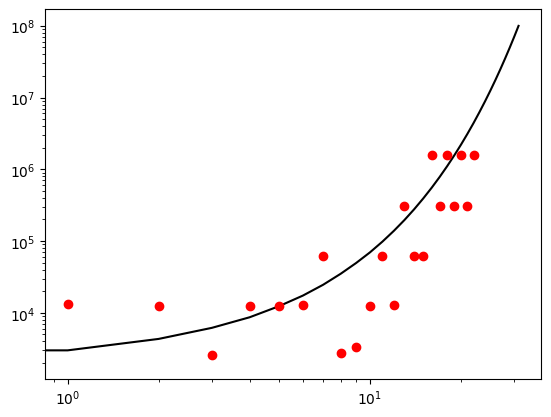

In [204]:
plt.plot(D,M,'k-')
plt.plot(D,10*M_signal,'ro')
plt.xscale('log')
plt.yscale('log')

In [230]:
print(grid[900])

-0.1563724207264554
